<a href="https://www.kaggle.com/code/clemwo/coffee-sales-eda-modeling-w-prophet-more?scriptVersionId=194106312" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
IMPORT_ADDITIONAL = True
if IMPORT_ADDITIONAL:
    !pip install prophet

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/coffee-sales/index.csv


<img src="https://nmgprod.s3.amazonaws.com/media/files/86/53/8653b96f15861cf643cc136bf94db701/cover_image_1587766077.jpg.760x400_q85_crop_upscale.jpg" alt="Coffee Sales" width="800"/>

# ☕ Coffee Sales 💸 EDA & Modeling with Prophet, SARIMAX and ETS

> Exploratory data analysis on Kaggles [coffee sales](https://www.kaggle.com/datasets/ihelon/coffee-sales) time series dataset which contains detailed records of coffee sales from a vending machine.

The dataset consists of the following six columns:

| Column | Description | 
| ------ | ----------- |
| `date` | Date of purchase |
| `datetime` | Datetime of purchase |
| `cash_type` | Cash or card purchasing |
| `card` | Anonymous card number |
| `money` | Amount of money in Ukranian hryvnias |
| `coffee_name` | Coffee type |

In [3]:
df = pd.read_csv('/kaggle/input/coffee-sales/index.csv')
print(f"Rows: {df.shape[0]:,}")
print(f"Cols: {df.shape[1]:,}")
print(df.dtypes)
df.head(3)

Rows: 1,313
Cols: 6
date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate


In [4]:
print(f"cash_type")
print("=========")
print(df['cash_type'].value_counts())
print()
print(f"coffee_name")
print("===========")
print(df['coffee_name'].value_counts())

cash_type
cash_type
card    1224
cash      89
Name: count, dtype: int64

coffee_name
coffee_name
Americano with Milk    319
Latte                  282
Cappuccino             222
Americano              185
Cortado                123
Hot Chocolate           79
Espresso                59
Cocoa                   44
Name: count, dtype: int64


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

df['month'] = df.index.to_period('M')
monthly_money_avg = df.groupby('month')['money'].transform('mean')
monthly_money_avg = pd.DataFrame(monthly_money_avg).reset_index()
monthly_money_avg['month'] = monthly_money_avg['datetime'].dt.to_period('M')

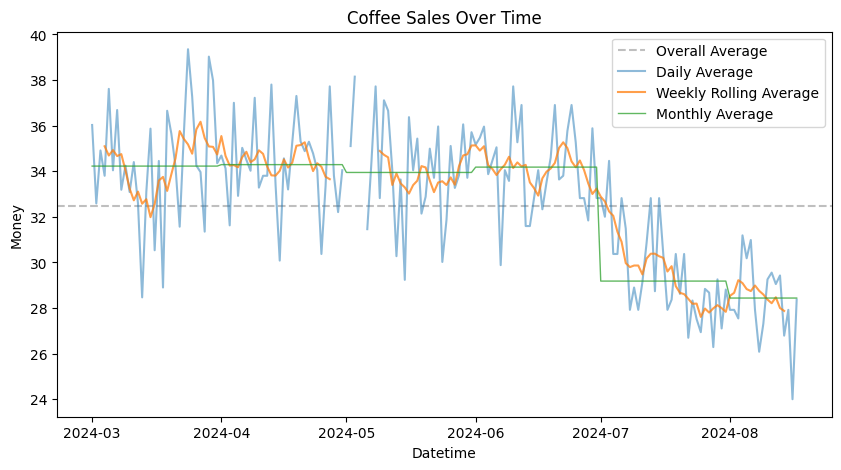

In [6]:
# ------------------------------------ #
# Plot coffee sales behavior over time #
# ------------------------------------ #

overall_avg = df['money'].mean()
daily_avg = df['money'].resample('D').mean()
weekly_rolling_avg = daily_avg.rolling(window=7, center=True).mean()

temp = pd.DataFrame(daily_avg).reset_index()
temp['month'] = temp['datetime'].dt.to_period('M')
monthly_avg = pd.merge(left=temp, right=monthly_money_avg, on=['month'], how='left')
monthly_avg.rename(columns={
    'datetime_x': 'datetime',
    'money_y': 'avg_monthly_money'
}, inplace=True)

plt.figure(figsize=(10, 5))

plt.axhline(y=overall_avg, color='grey', alpha=0.5, linestyle='--', label='Overall Average')
plt.plot(daily_avg, alpha=0.5, color='C0', label='Daily Average')
plt.plot(weekly_rolling_avg, color='C1', alpha=0.75, label='Weekly Rolling Average')
plt.plot(monthly_avg['datetime'], monthly_avg['avg_monthly_money'], alpha=0.75, color='C2', lw=1, label='Monthly Average')

plt.xlabel('Datetime')
plt.ylabel('Money')
plt.title('Coffee Sales Over Time')
plt.legend(loc='upper right')
plt.grid(False)

plt.show()

The dataset contains five month of coffee sales date, starting from March until August 2024. The sales show steady behavior until July 2024. From end of June 2024 until August 2024 the sales are dropping steadily. In May 2024, there are some missing data points.

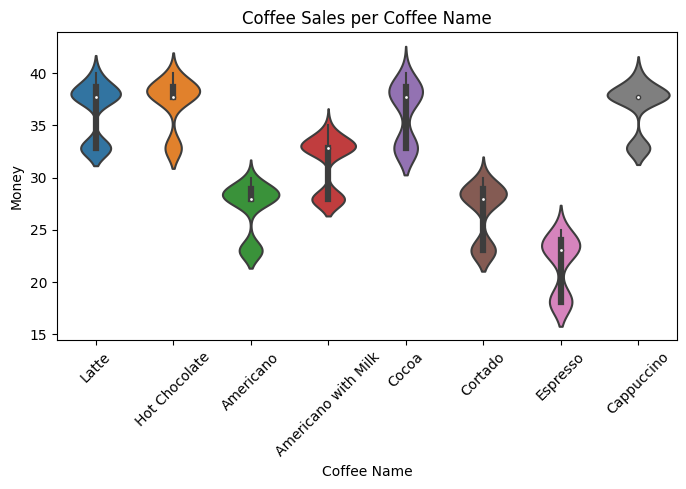

In [7]:
# ---------------------------- #
# Coffee sales per coffee name #
# ---------------------------- #

plt.figure(figsize=(8, 4))
sns.violinplot(x='coffee_name', y='money', data=df)
plt.title('Coffee Sales per Coffee Name')
plt.xlabel('Coffee Name')
plt.ylabel('Money')
plt.xticks(rotation=45)

plt.show()

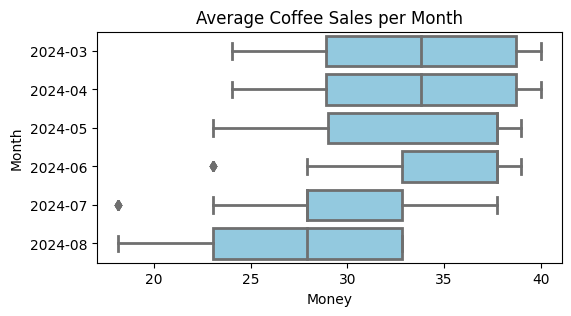

In [8]:
# ---------------------- #
# Coffee sales per month #
# ---------------------- #

plt.figure(figsize=(6, 3))
sns.boxplot(x='money', y='month', data=df, color='skyblue', linewidth=2)
plt.title('Average Coffee Sales per Month')
plt.xlabel('Money')
plt.ylabel('Month')
plt.grid(False)

plt.show()

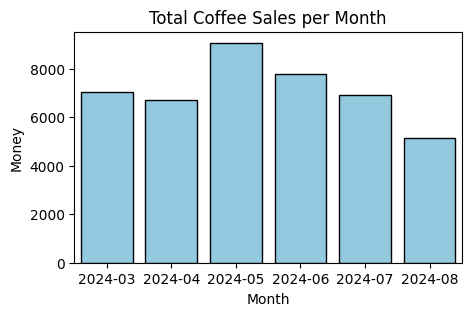

In [9]:
# ---------------------------- #
# Total coffee sales per month #
# ---------------------------- #

df['month'] = df.index.to_period('M')
monthly_money_sum = df.groupby('month')['money'].aggregate('sum')
monthly_money_sum = pd.DataFrame(monthly_money_sum).reset_index()
plt.figure(figsize=(5, 3))
sns.barplot(data=monthly_money_sum, x='month', y='money', 
            color='skyblue', edgecolor='black', linewidth=1);
plt.title('Total Coffee Sales per Month')
plt.xlabel('Month')
plt.ylabel('Money')
plt.show()

## ⏰ Hourly Distribution

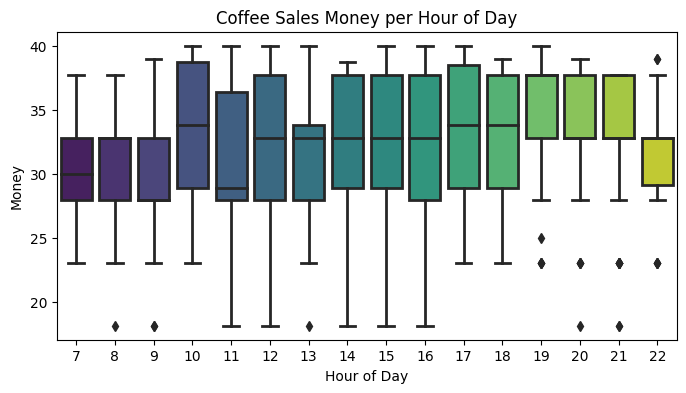

In [10]:
df['hour'] = df.index.hour

plt.figure(figsize=(8, 4))
sns.boxplot(x='hour', y='money', data=df, palette='viridis', linewidth=2)
plt.title('Coffee Sales Money per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Money')
plt.grid(False)

plt.show()

### Sales per Hour

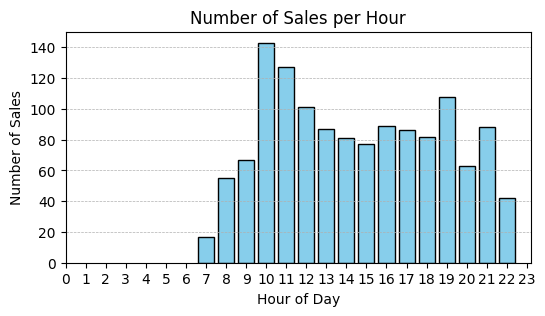

In [11]:
sales_per_hour = df.groupby('hour').size().reset_index(name='sales_count')

plt.figure(figsize=(6, 3))
plt.bar(sales_per_hour['hour'], sales_per_hour['sales_count'], 
            color='skyblue', edgecolor='black', linewidth=1)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sales')
plt.title('Number of Sales per Hour')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

There are no coffee sales for the hours between 11pm and 6am. The highest number of sales is clearly at 10am in the morning. 

In [12]:
# ------------------------------------------------------------ #
# Calculate statistics per day of the week and hour of the day #
# ------------------------------------------------------------ #

df['day_of_week'] = df.index.day_name()

daily_hourly_summary = df.groupby(['day_of_week', 'hour'])\
    .agg({'money': ['count', 'sum', 'mean']}).reset_index()
daily_hourly_summary.head(3)

day_of_week hour money                   
                   count     sum       mean
0      Friday    7     3   93.56  31.186667
1      Friday    8     4  121.48  30.370000
2      Friday    9    12  346.12  28.843333

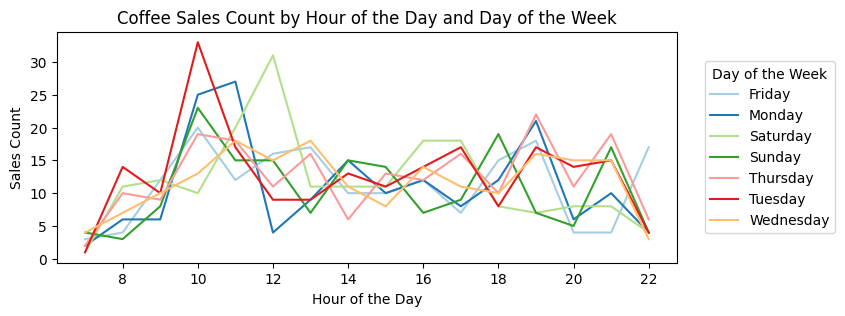

In [13]:
plt.figure(figsize=(8, 3))
sns.lineplot(data=daily_hourly_summary, x='hour', y=('money', 'count'), 
             hue='day_of_week', palette='Paired')
plt.xlabel('Hour of the Day')
plt.ylabel('Sales Count')
plt.title('Coffee Sales Count by Hour of the Day and Day of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.15, 0.5), loc='center');

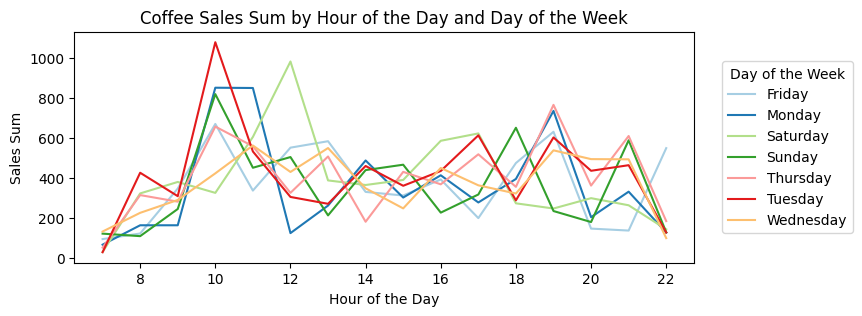

In [14]:
plt.figure(figsize=(8, 3))
sns.lineplot(data=daily_hourly_summary, x='hour', y=('money', 'sum'), 
             hue='day_of_week', palette='Paired')
plt.xlabel('Hour of the Day')
plt.ylabel('Sales Sum')
plt.title('Coffee Sales Sum by Hour of the Day and Day of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.15, 0.5), loc='center');

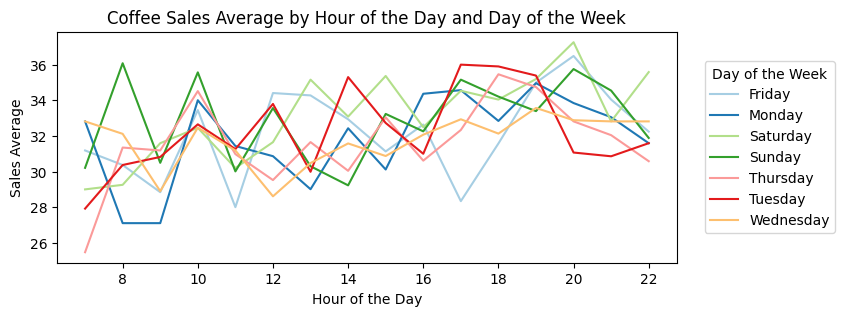

In [15]:
plt.figure(figsize=(8, 3))
sns.lineplot(data=daily_hourly_summary, x='hour', y=('money', 'mean'), 
             hue='day_of_week', palette='Paired')
plt.xlabel('Hour of the Day')
plt.ylabel('Sales Average')
plt.title('Coffee Sales Average by Hour of the Day and Day of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.15, 0.5), loc='center');

## 📊 Time Series Decomposition

In [16]:
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
temp = df.reset_index()[['datetime', 'money']].copy()
temp.index = np.array(temp['datetime'], dtype=np.datetime64)
temp = temp[['money']]
temp.head(3)

,money
2024-03-01 10:15:50.520,38.7
2024-03-01 12:19:22.539,38.7
2024-03-01 12:20:18.089,38.7


Daily Coffee Sales (Sum) Decomposition


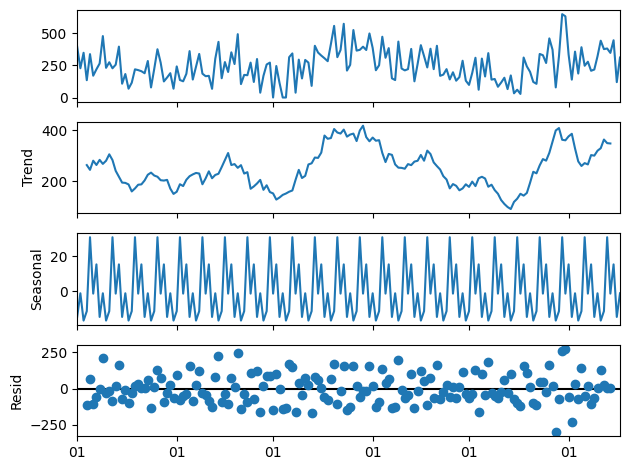

In [18]:
print('Daily Coffee Sales (Sum) Decomposition')
print('======================================')
daily_data = temp.resample('D').sum()
result = seasonal_decompose(daily_data.dropna(), model='additive')
result.plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.show()

There is a strong weekly seasonality pattern.

Daily Coffee Sales (Avg) Decomposition


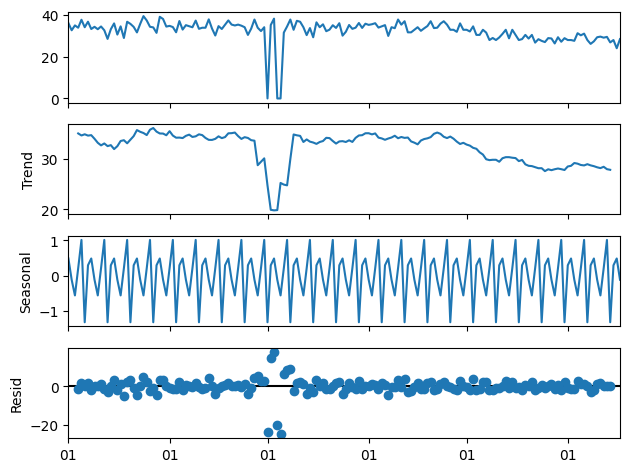

In [19]:
print('Daily Coffee Sales (Avg) Decomposition')
print('======================================')
daily_data = temp.resample('D').mean()
daily_data = daily_data.dropna().asfreq('D', fill_value=0)
result = seasonal_decompose(daily_data.dropna(), model='additive')
result.plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.show()

## 📈 Trend Analysis

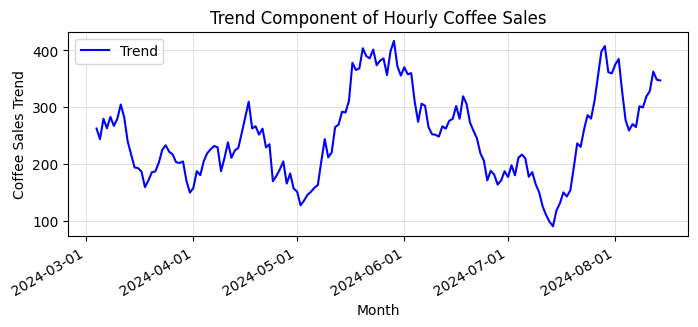

The slope of the trend component is: 0.3410324626742411


In [20]:
daily_data = temp.resample('D').sum()
result = seasonal_decompose(daily_data.dropna(), model='additive')
trend = result.trend.dropna()

plt.figure(figsize=(8, 3))
plt.plot(trend.index, trend, label='Trend', color='blue')
plt.xlabel('Month')
plt.ylabel('Coffee Sales Trend')
plt.title('Trend Component of Hourly Coffee Sales')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='lightgrey')
plt.gcf().autofmt_xdate()

plt.show()

trend_slope = np.polyfit(range(len(trend)), trend, 1)[0]
print(f"The slope of the trend component is: {trend_slope}")

No clearly visible upwards nor downwards trend is visible for the whole time frame. 

# 🔧 Modeling

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 📉 Stationarity Test

In [22]:
def interpret_adfuller_test(pvalue, sig_level):
    if pvalue < sig_level: 
        return "REJECT H_0: The time series is stationary!"
    return "Cannot reject H_0: The time series is not stationary!"

In [23]:
SIGNIFICANCE_LEVEL = 0.05

result = adfuller(df['money'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(interpret_adfuller_test(result[1], SIGNIFICANCE_LEVEL))

ADF Statistic: -2.6480158561228606
p-value: 0.08347377134473771
Cannot reject H_0: The time series is not stationary!


The result of the Augmented Dickey-Fuller (ADF) test helps determine if the time series is stationary or not

$$
    H_0 = \text{The time series has a unit root, i.e., it is not stationary} \\
    H_1 = \text{The time series does not have a unit root, i.e., it is stationary}
$$

Since the $p$-value is less than $0.05$, the null hypothesis ($H_0$) can be rejected. Thus, it can be concluded that __the time series is _stationary___. Since the time series is stationary, not further differencing needs to be performed to fit e.g. an ARIMA model. 

## 📐 SARIMAX

Since there were clear seasonal effect visible in the data, [SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) (seasonal ARIMA) instead of ARIMA should be used.

### Pre-Process Data

Since coffee sales are recorded with specific timestamps, the data needs to be aggregated to a daily frequency before fitting the ARIMA model.

In [24]:
daily_sales = df.groupby('date')['money'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)
daily_sales = daily_sales.asfreq('D', fill_value=0)  # Ensure the index has a daily frequency.
print(f"Number of days: {daily_sales.shape[0]}")
daily_sales.head(3)

Number of days: 170


date
2024-03-01    396.3
2024-03-02    228.1
2024-03-03    349.1
Freq: D, Name: money, dtype: float64

In [25]:
seasonal_diff = daily_sales.diff(7).dropna()
seasonal_diff.head(3)

date
2024-03-08   -130.8
2024-03-09    251.3
2024-03-10   -117.5
Freq: D, Name: money, dtype: float64

### Identify Parameters

- $P$: Seasonal autoregressive order
- $D$: Seasonal differencing order
- $Q$: Seasonal moving average orders
- $s$: Length of the seasonal cycle  (e.g., 7 for weekly seasonality if the data is daily)

To run ARIMA (or SARIMAX) values for $P$ (AR term), $Q$ (MA term), $D$ and $s$ need to be identified. For this ACF and PACF plots as well as manual interpretations can be used:

- [ACF](https://en.wikipedia.org/wiki/Autocorrelation): 
    - Shows the correlation of the time series with its own lagged values.
    - Helps identify the MA (Moving Average) term (q).
- [PACF](https://en.wikipedia.org/wiki/Partial_autocorrelation_function): 
    - Shows the correlation of the time series with its own lagged values, but after removing the effects of intermediate lags.
    - Helps identify the AR (AutoRegressive) term (p). 

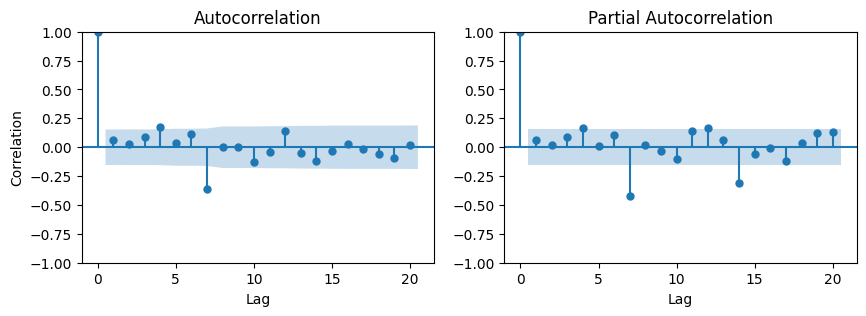

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(seasonal_diff, lags=20, ax=axes[0])
plot_pacf(seasonal_diff, lags=20, ax=axes[1])
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
axes[1].set_xlabel('Lag')
plt.show()

__Identifying $p$ (AR term) from PACF__

- Look for the lag at which the PACF plot cuts off (i.e., the lag after which the PACF values drop to zero or become statistically insignificant). This lag value is the AR term ($p$).
- The ACF plot shows significant spikes at lag 1, which then quickly drop to near-zero values.

__Identifying $q$ (MA term) from ACF__

- Look for the lag at which the ACF plot cuts off (i.e., the lag after which the ACF values drop to zero or become statistically insignificant). This lag value is the MA term ($q$).
- The PACF plot shows a significant spike at lag 1, which then quickly drops to near-zero values.

__Identifying $D$__

- Since seasonal differencing has been performed, this is 1.
- For normal ARIMA this would be 0 if the ADF test showed that the series is stationary and 1 otherwise.

__Identifying $s$__

- In the previously performed seasonality decomposition analysis a clear weekly seasonality was observable. Thus, the value should be 7.

In [27]:
# --- Seasonal parameters ---

P = 1  # = p = AR term
Q = 1  # = q = MA term
D = 1  # Since seasonal differencing has been performed
s = 7  # Since weekly seasonality has been observed


# --- Non-seasonal parameters ---

p_AR_term = 1
q_MA_term = 1
d_differencing_term = 1

### Fitting the Model

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
# --- Fit the model ---

model = SARIMAX(daily_sales, 
                order=(p_AR_term, d_differencing_term, q_MA_term),
                seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             money   No. Observations:                  170
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1019.653
Date:                           Mon, 26 Aug 2024   AIC                           2049.307
Time:                                   07:12:01   BIC                           2064.745
Sample:                               03-01-2024   HQIC                          2055.575
                                    - 08-17-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0307      0.101     -0.303      0.762      -0.229       0.168
ma.L1         -0.7916      0.062    -12.849

In [30]:
# --- Forecast future values ---

forecast = model_fit.forecast(steps=30)
forecast_df = pd.DataFrame(forecast)
forecast_df.index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
print(f"Predicted days: {forecast_df.shape[0]}")
forecast_df.head(3)

Predicted days: 30


,predicted_mean
2024-08-18,299.169047
2024-08-19,302.330162
2024-08-20,343.473063


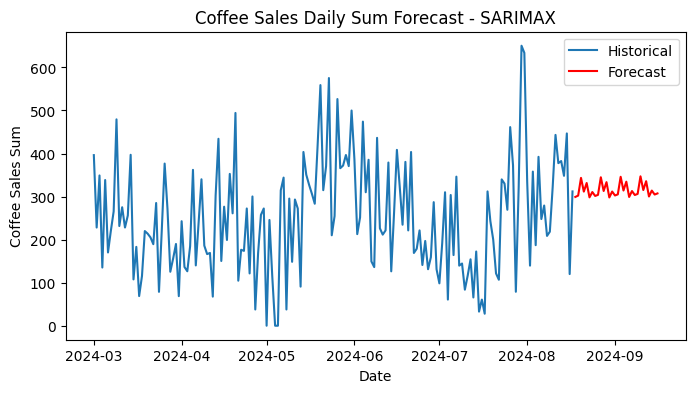

In [31]:
# --- Plot the forecast ---

plt.figure(figsize=(8, 4))
plt.plot(daily_sales, label='Historical')
plt.plot(forecast_df, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Coffee Sales Sum')
plt.title('Coffee Sales Daily Sum Forecast - SARIMAX')
plt.legend()
plt.show()

### Review Residuals

The [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals) (i.e., the difference between the actual and predicted values) should be normally distributed and show no autocorrelation. If they don’t, the model might be misspecified. We can check this by plotting the residuals and perform a [Ljung-Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test).

In [32]:
residuals = model_fit.resid

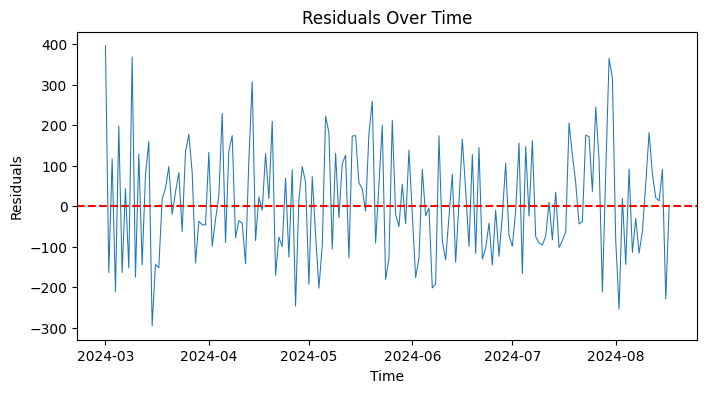

In [33]:
plt.figure(figsize=(8, 4))

plt.plot(residuals, linewidth=0.75)
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.show()

__Generally__

Residuals should ideally have no discernible pattern over time. If there is a pattern (e.g., a trend or autocorrelation), it suggests that the model has not fully captured the underlying structure of the data.

__Intepretation__

We can't see any specific pattern over time. 

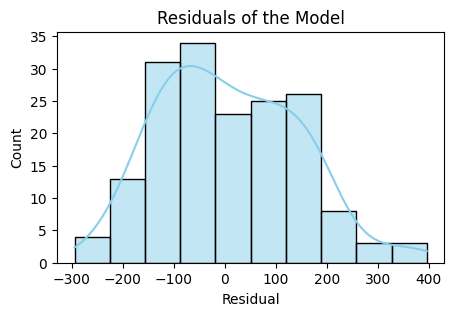

In [34]:
plt.figure(figsize=(5, 3))
sns.histplot(residuals, color='skyblue', edgecolor='black', linewidth=1, kde=True)
plt.xlabel('Residual')
plt.title('Residuals of the Model')
plt.show()

__Interpretation__

The residuals are roughly normally distributed, which suggest that the model errors are random and that the model is likely well-specified.

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox

SIGNIFICANCE_LEVEL = 0.05

ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
pvalue = ljung_box_results['lb_pvalue'].values

print(ljung_box_results)
if pvalue > SIGNIFICANCE_LEVEL:
    print("No significant autocorrelation in the residuals (fail to reject H0)")
else:
    print("There is significant autocorrelation in the residuals (reject H0)")

      lb_stat  lb_pvalue
10  15.457771   0.116242
No significant autocorrelation in the residuals (fail to reject H0)


__Description of the outputs__

- `lb_stat` (Ljung-Box Statistic): Is a measure of the overall departure of the observed autocorrelations from zero up to the specified number of lags (in this case, lag 10).
- `lb_pvalue`: Indicates the probability of observing the test results under the null hypothesis $H_0$ that the residuals are independently distributed (i.e., no autocorrelation).

The null hypothesis $H_0$ of the Ljung-Box test is that there is no autocorrelation in the residuals up to the specified lag (in this case, lag 10). If the $p$-value is below the significance level (e.g. 0.05) we can reject $H_0$, which indicates that there is significant autocorrelation in the residuals.

__Interpretation & Conclusion__ 

- The $p$-value is 0.116242, which is greater than 0.05.
- Thus, we do not have enough evidence to reject $H_0$. 
- This suggests that there is no significant autocorrelation in the residuals up to lag 10.

This can be seen as a good sign for our model, as it indicates that the residuals are not correlated, meaning your model has likely captured the underlying patterns in the data well without leaving behind any autocorrelated structure in the residuals.

## 🔍 Tune Model Parameters - GridSearch

The parameters $p$,$d$,$q$,$P$,$D$,$Q$,$s$ significantly impact the model's performance. Thus, it makes sense to tune these parameters. [`pmdarima`](https://pypi.org/project/pmdarima/1.5.0/) is a package which let's you automatically try different parameter combinations and select the best based on AIC or BIC. But I can't `pip install` it somehow. Therefore, we are going to use classical [`GridSearch`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) in this section. 

We are going to choose a model that minimizes the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC), which is a measure of the model's quality. 
The lower the AIC, the better the model.

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX


p = d = q = range(0, 3)                               # Define the p, d, q parameters to take any value between  0 and 2.
pdq = list(itertools.product(p, d, q))                # Generate all different combinations of p, d, q triplets.
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Generate all different combinations of seasonal p, d, q triplets.

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

length_of_seasonal_cycle = 12

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(daily_sales,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal

            print(f'SARIMA{param}x{param_seasonal}{length_of_seasonal_cycle} - AIC:{results.aic}')
        except Exception as e:
            continue

print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq} - AIC: {best_aic}')

## 🔄 Cross-Validation

In [37]:
n_splits = 5
size = len(daily_sales) // (n_splits + 1)
errors = []

for i in range(n_splits):
    train = daily_sales[:size*(i+1)]
    val = daily_sales[size*(i+1):size*(i+2)]

    try:
        model = SARIMAX(train, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False, maxiter=1_000)
        
        forecast = model_fit.forecast(steps=len(val))
        error = mean_squared_error(val, forecast)
        errors.append(error)
        print(f"Fold {i+1} - MSE: {error}")
    except Exception as e:
        print(f"Fold {i+1} - Failed: {e}")
        errors.append(np.nan)

average_mse = np.nanmean(errors)
print(f"Average MSE: {average_mse}")

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold 1 - MSE: 2331090.4375979113


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 - MSE: 61899.56332305046
Fold 3 - MSE: 45789.19729337292
Fold 4 - MSE: 24565.9555202604
Fold 5 - MSE: 54889.5161156054
Average MSE: 503646.93397004006


## 📈 Facebook's Prophet

In this section we are going to use Facebook's open-source model [prophet](https://github.com/facebook/prophet) instead of SARIMAX.

07:15:24 - cmdstanpy - INFO - Chain [1] start processing
07:15:24 - cmdstanpy - INFO - Chain [1] done processing


Validation MSE: 24214.304860551045
Validation MAE: 125.95033183581529


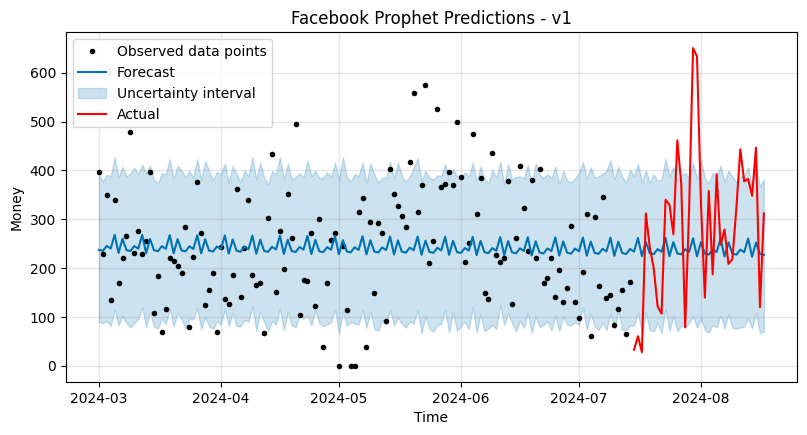

In [38]:
# ----------- #
# Preparation #
# ----------- #

df = daily_sales.reset_index()
df.columns = ['ds', 'y']

# Split into training and validation sets.
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
val_df = df[train_size:]


# --------- #
# Modelling #
# --------- #

# Fit model on training set.
model = Prophet()
model.fit(train_df)

# Hold predictions for the validation set period.
future_val = model.make_future_dataframe(periods=len(val_df), freq='D')
forecast_val = model.predict(future_val)

# Extract the relevant portion of the forecast for the validation period.
forecast_val_trimmed = forecast_val[-len(val_df):]

# Performance metrics.
mse = mean_squared_error(val_df['y'], forecast_val_trimmed['yhat'])
mae = mean_absolute_error(val_df['y'], forecast_val_trimmed['yhat'])

print(f'Validation MSE: {mse}')
print(f'Validation MAE: {mae}')


# -------- #
# Plotting #
# -------- #
fig = model.plot(forecast_val)
fig.set_size_inches(8, 4)

ax = fig.gca()
ax.plot(val_df['ds'], val_df['y'], 'r', label='Actual')
plt.title('Facebook Prophet Predictions - v1')
plt.xlabel('Time')
plt.ylabel('Money')
plt.legend()

plt.show()

The model looks pretty bad. It only captures very general behavior but nothing related to the actual effects. Let's try to include seasonality specifications to improve the models performance. 

07:15:25 - cmdstanpy - INFO - Chain [1] start processing
07:15:25 - cmdstanpy - INFO - Chain [1] done processing


Validation MSE: 49259.52095429318
Validation MAE: 183.68678448370406


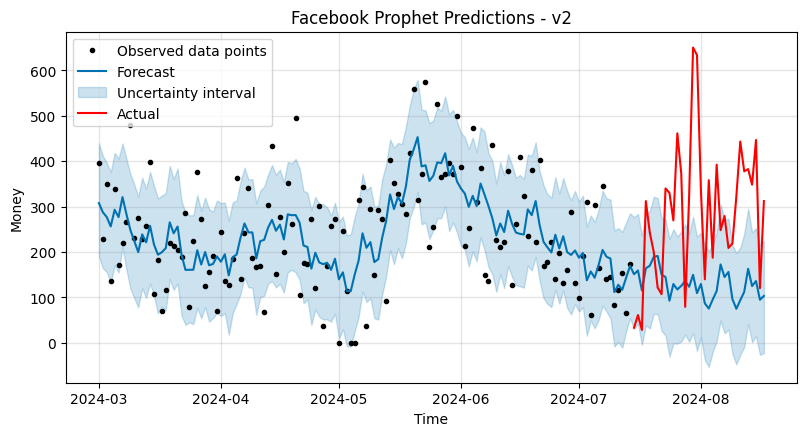

In [39]:
# --------- #
# Modelling #
# --------- #

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train_df)

future_val = model.make_future_dataframe(periods=len(val_df), freq='D')
forecast_val = model.predict(future_val)
forecast_val_trimmed = forecast_val[-len(val_df):]

mse = mean_squared_error(val_df['y'], forecast_val_trimmed['yhat'])
mae = mean_absolute_error(val_df['y'], forecast_val_trimmed['yhat'])

print(f'Validation MSE: {mse}')
print(f'Validation MAE: {mae}')


# -------- #
# Plotting #
# -------- #
fig = model.plot(forecast_val)
fig.set_size_inches(8, 4)

ax = fig.gca()
ax.plot(val_df['ds'], val_df['y'], 'r', label='Actual')
plt.title('Facebook Prophet Predictions - v2')
plt.xlabel('Time')
plt.ylabel('Money')
plt.legend()

plt.show()

The model looks much better. It seems to predict actual behavior. However, it has difficulty to perform on the validation set. The MSE and MAE are worse than before. But this seems to be because it follows the downwards trends which starts in mid May 2024 while in reality (red line) from mid July onwards the trend is not downwards anymore but rather slightly upwards. 

07:15:43 - cmdstanpy - INFO - Chain [1] start processing
07:15:43 - cmdstanpy - INFO - Chain [1] done processing


Validation MSE: 349240.95548801735
Validation MAE: 522.9212478049341


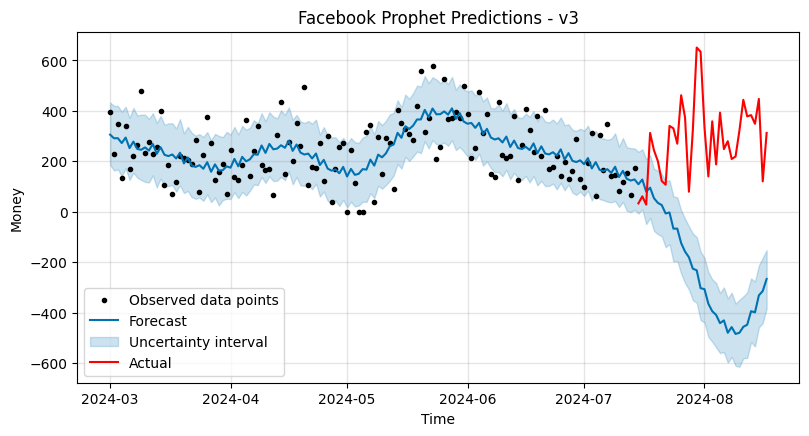

In [44]:
# --------- #
# Modelling #
# --------- #

model = Prophet(
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=10.0,
    yearly_seasonality=True
)
model.fit(train_df)

future_val = model.make_future_dataframe(periods=len(val_df), freq='D')
forecast_val = model.predict(future_val)
forecast_val_trimmed = forecast_val[-len(val_df):].copy()

forecast_val_trimmed['yhat_upper'] = forecast_val_trimmed['yhat'] + forecast_val_trimmed['yhat'].std() * 1.5
forecast_val_trimmed['yhat_lower'] = forecast_val_trimmed['yhat'] - forecast_val_trimmed['yhat'].std() * 1.5

mse = mean_squared_error(val_df['y'], forecast_val_trimmed['yhat'])
mae = mean_absolute_error(val_df['y'], forecast_val_trimmed['yhat'])

print(f'Validation MSE: {mse}')
print(f'Validation MAE: {mae}')


# -------- #
# Plotting #
# -------- #
fig = model.plot(forecast_val)
fig.set_size_inches(8, 4)

ax = fig.gca()
ax.plot(val_df['ds'], val_df['y'], 'r', label='Actual')
plt.title('Facebook Prophet Predictions - v3')
plt.xlabel('Time')
plt.ylabel('Money')
plt.legend()

plt.show()

In [45]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='90 days', period='90 days', horizon='10 days')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/1 [00:00<?, ?it/s]

07:15:44 - cmdstanpy - INFO - Chain [1] start processing
07:15:44 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,31174.364111,176.562635,176.562635,0.581372,0.581372,0.819625,0.0
1,2 days,357.338302,18.903394,18.903394,0.115194,0.115194,0.122235,1.0
2,3 days,37796.475864,194.413158,194.413158,0.561369,0.561369,0.780420,0.0
3,4 days,883.280110,29.720029,29.720029,0.212894,0.212894,0.192412,1.0
4,5 days,5435.103069,73.723152,73.723152,0.510195,0.510195,0.406498,1.0
5,6 days,14948.815607,122.265349,122.265349,1.459710,1.459710,0.843834,1.0
6,7 days,21334.386750,146.062955,146.062955,1.252899,1.252899,0.770328,0.0
7,8 days,9775.568587,98.871475,98.871475,0.640774,0.640774,0.485293,1.0
8,9 days,55188.443048,234.922206,234.922206,3.578949,3.578949,1.283019,0.0
9,10 days,26701.395574,163.405617,163.405617,0.947718,0.947718,0.643018,0.0


## ⏳ Exponential Smoothing (ETS)

In this section we are going to try a different method, called [Exponential Smoothing State Space Model](https://en.wikipedia.org/wiki/Exponential_smoothing) (ETS). ETS captures error, trend, and seasonality in time series data through additive or multiplicative components. It's particularly effective when dealing with strong seasonal patterns and trends, making it a good alternative to Prophet for simple, robust forecasting and SARIMAX for cases where model interpretability and parameter simplicity are preferred. 

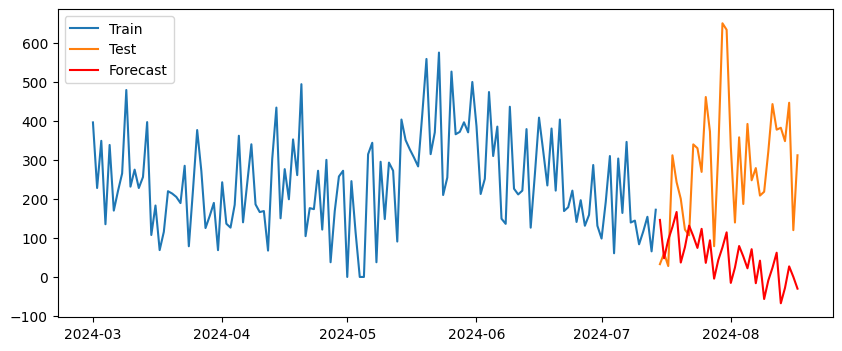

Test MSE: 82318.43839034485
Test MAE: 247.65640413460898


In [46]:
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]


# --------- #
# Modelling #
# --------- #

# Initialize and fit ETS model.
model = ExponentialSmoothing(train, 
                             trend='add', 
                             seasonal='add', 
                             seasonal_periods=12)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏